In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/DL/fruit_data.zip" .

In [ ]:
!unzip fruit_data.zip

Archive:  fruit_data.zip
   creating: fruit_data/
   creating: fruit_data/train/
   creating: fruit_data/train/freshoranges/
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.08.09 AM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.08.29 AM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.00.23 AM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.59.54 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.56.02 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.50.28 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.53.33 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-12 at 11.52.21 PM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.04.51 AM.png  
  inflating: fruit_data/train/freshoranges/Screen Shot 2018-06-13 at 12.10.10 AM.png  
  inf

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

import random
random.seed(0)

torch.manual_seed(40)

In [ ]:
rotation_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

horizontal_flip_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

basic_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
train_set = ImageFolder("./fruit_data/train", basic_transforms)
train_hor_flip = ImageFolder("./fruit_data/train", horizontal_flip_transform)
train_rotate = ImageFolder("./fruit_data/train", rotation_transform)
val_set = ImageFolder("./fruit_data/valid", basic_transforms)

train_set_augmented = torch.utils.data.ConcatDataset([train_set, train_hor_flip, train_rotate])

In [ ]:
from torch.utils import data

train_dataloader = data.DataLoader(train_set_augmented, batch_size=16, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=16, shuffle=True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torchvision import models
from torch import nn

class ResNet50Model(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.resnet = models.resnet50(pretrained=True)
    self.resnet.fc = nn.Linear(in_features=2048, out_features=6, bias=True)


  def forward(self, x):
    return self.resnet(x)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet50Model()
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


ResNet50Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [ ]:
from torch import optim
from tqdm import tqdm

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_model(dataloader, model, loss_fn, optimizer):
  pred_list = torch.tensor([]).to(device)
  true_list = torch.tensor([]).to(device)
  losses = []
  model.train()
  for d in tqdm(dataloader):
    inputs, labels = d
    outputs = model(inputs.to(device))
    logits = torch.argmax(outputs, dim=1)

    pred_list = torch.concatenate([pred_list, logits])
    true_list = torch.concatenate([true_list, labels.to(device)])

    loss = loss_fn(outputs, labels.to(device))
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return torch.mean(torch.tensor(losses)).item(), true_list.detach(), pred_list.detach()


def eval_model(dataloader, model, loss_fn):
  pred_list = torch.tensor([]).to(device)
  true_list = torch.tensor([]).to(device)
  losses = []
  model.eval()
  with torch.no_grad():
    for d in tqdm(dataloader):
      inputs, labels = d
      outputs = model(inputs.to(device))
      logits = torch.argmax(outputs, dim=1)

      pred_list = torch.concatenate([pred_list, logits])
      true_list = torch.concatenate([true_list, labels.to(device)])

      loss = loss_fn(outputs, labels.to(device))
      losses.append(loss.item())

  return torch.mean(torch.tensor(losses)).item(), true_list, pred_list




In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
EPOCH = 10
history = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

for i in range(EPOCH):
  print(f"Training epoch {i+1}/{EPOCH}")
  loss, true_list, pred_list = train_model(train_dataloader, model, loss_fn, optimizer)

  acc = accuracy_score(true_list.cpu().numpy(), pred_list.cpu().numpy())

  print(f"train loss : {loss}, train acc : {acc}")

  history["train_loss"].append(loss)
  history["train_acc"].append(acc)

  loss, true_list, pred_list = eval_model(val_dataloader, model, loss_fn)

  acc = accuracy_score(true_list.cpu().numpy(), pred_list.cpu().numpy())

  print(f"val loss : {loss}, val acc : {acc}")

  history["val_loss"].append(loss)
  history["val_acc"].append(acc)



Training epoch 1/10


100%|██████████| 222/222 [00:49<00:00,  4.51it/s]


train loss : 0.19720929861068726, train acc : 0.9379582628313593


100%|██████████| 21/21 [00:02<00:00,  7.13it/s]


val loss : 0.04021577537059784, val acc : 0.9878419452887538
Training epoch 2/10


100%|██████████| 222/222 [00:40<00:00,  5.45it/s]


train loss : 0.051287274807691574, train acc : 0.9833615341229555


100%|██████████| 21/21 [00:02<00:00,  7.05it/s]


val loss : 0.0574927031993866, val acc : 0.9878419452887538
Training epoch 3/10


100%|██████████| 222/222 [00:40<00:00,  5.51it/s]


train loss : 0.0598352774977684, train acc : 0.9836435420191766


100%|██████████| 21/21 [00:02<00:00,  7.18it/s]


val loss : 0.016125179827213287, val acc : 0.9969604863221885
Training epoch 4/10


100%|██████████| 222/222 [00:40<00:00,  5.42it/s]


train loss : 0.022726887837052345, train acc : 0.9929498025944726


100%|██████████| 21/21 [00:03<00:00,  6.05it/s]


val loss : 0.027977565303444862, val acc : 0.993920972644377
Training epoch 5/10


100%|██████████| 222/222 [00:40<00:00,  5.55it/s]


train loss : 0.03678771108388901, train acc : 0.988155668358714


100%|██████████| 21/21 [00:03<00:00,  5.77it/s]


val loss : 0.02740846388041973, val acc : 0.9908814589665653
Training epoch 6/10


100%|██████████| 222/222 [00:39<00:00,  5.57it/s]


train loss : 0.017054717987775803, train acc : 0.9952058657642414


100%|██████████| 21/21 [00:02<00:00,  7.21it/s]


val loss : 0.022204799577593803, val acc : 0.9908814589665653
Training epoch 7/10


100%|██████████| 222/222 [00:40<00:00,  5.53it/s]


train loss : 0.011096333153545856, train acc : 0.9980259447264523


100%|██████████| 21/21 [00:02<00:00,  7.12it/s]


val loss : 0.0291657242923975, val acc : 0.993920972644377
Training epoch 8/10


100%|██████████| 222/222 [00:41<00:00,  5.38it/s]


train loss : 0.02231401577591896, train acc : 0.9949238578680203


100%|██████████| 21/21 [00:02<00:00,  7.13it/s]


val loss : 0.02900160849094391, val acc : 0.9878419452887538
Training epoch 9/10


100%|██████████| 222/222 [00:40<00:00,  5.53it/s]


train loss : 0.011321838945150375, train acc : 0.9960518894529047


100%|██████████| 21/21 [00:02<00:00,  7.11it/s]


val loss : 0.040481988340616226, val acc : 0.9878419452887538
Training epoch 10/10


100%|██████████| 222/222 [00:40<00:00,  5.53it/s]


train loss : 0.008930068463087082, train acc : 0.9977439368302312


100%|██████████| 21/21 [00:03<00:00,  6.17it/s]

val loss : 0.0586400032043457, val acc : 0.9726443768996961


Text(0.5, 1.0, 'Loss Curve')

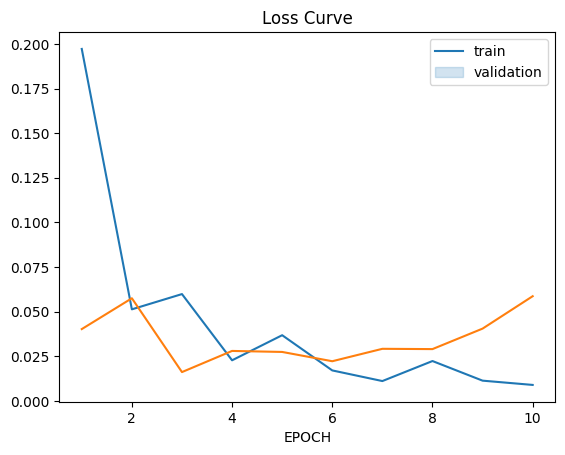

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(1,EPOCH+1), y=history['train_loss'])
sns.lineplot(x=range(1,EPOCH+1), y=history['val_loss'])
plt.legend(['train', 'validation'])
plt.xlabel("EPOCH")
plt.title("Loss Curve")

Text(0.5, 1.0, 'Accuracy')

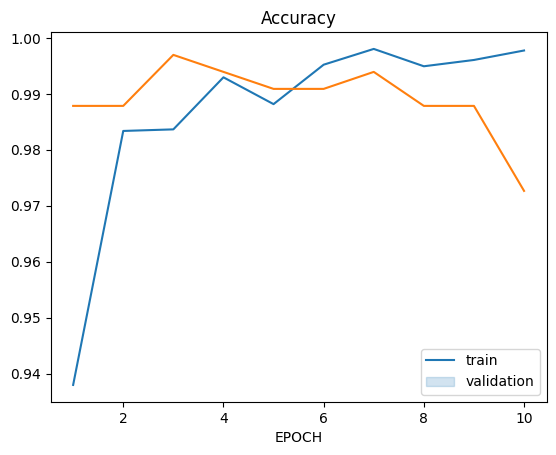

In [ ]:
sns.lineplot(x=range(1,EPOCH+1), y=history['train_acc'])
sns.lineplot(x=range(1,EPOCH+1), y=history['val_acc'])
plt.legend(['train', 'validation'])
plt.xlabel("EPOCH")
plt.title("Accuracy")

In [ ]:
print("ResNet50")
print(classification_report(true_list.cpu().numpy(), pred_list.cpu().numpy()))

ResNet50
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        50
         1.0       1.00      1.00      1.00        49
         2.0       0.98      0.95      0.96        43
         3.0       1.00      0.93      0.97        74
         4.0       1.00      1.00      1.00        68
         5.0       0.96      0.96      0.96        45

    accuracy                           0.97       329
   macro avg       0.97      0.97      0.97       329
weighted avg       0.97      0.97      0.97       329

